In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import ETTh1Dataset

In [2]:
series = ETTh1Dataset().load()

In [6]:
series_df = series.pd_dataframe()
series_df.head()

component,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


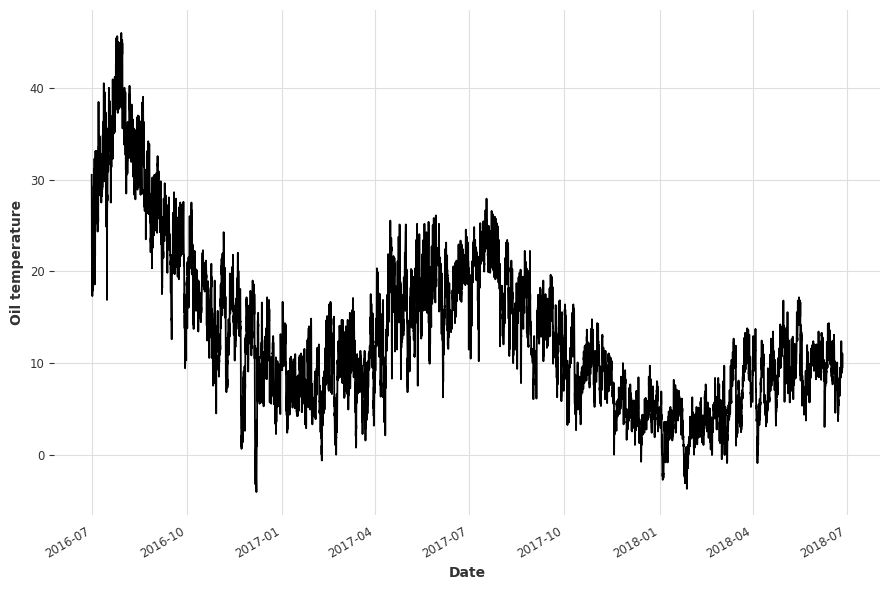

In [8]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(series_df['OT'])
ax.set_xlabel('Date')
ax.set_ylabel('Oil temperature')

fig.autofmt_xdate()
plt.tight_layout()

## Train/test split
Keep the last 96 time steps for the test set

In [3]:
train, test = series[:-96], series[-96:]

## Model training

In [9]:
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

tide = TiDEModel(
    input_chunk_length=720, 
    output_chunk_length=96,
    num_encoder_layers=2,
    num_decoder_layers=2,
    decoder_output_dim=32,
    hidden_size=512,
    temporal_decoder_hidden=16,
    use_layer_norm=True,
    dropout=0.5,
    random_state=42)

tide.fit(
    scaled_train,
    epochs=10
)

D:\Anaconda\lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 6.2 M 
4 | decoders         | Sequential       | 4.2 M 
5 | temporal_decoder | _ResidualBlock   | 892   
6 | lookback_skip    | Linear           | 69.2 K
------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.978    Total estimated model params

Epoch 9: 100%|███████████████████████████████████████████████████| 516/516 [00:55<00:00,  9.28it/s, train_loss=0.00658]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████| 516/516 [00:55<00:00,  9.28it/s, train_loss=0.00658]


TiDEModel(num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=16, use_layer_norm=True, dropout=0.5, use_static_covariates=True, input_chunk_length=720, output_chunk_length=96, random_state=42)

In [10]:
scaled_pred_tide = tide.predict(n=96)

pred_tide = train_scaler.inverse_transform(scaled_pred_tide)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


In [11]:
preds_df = pred_tide.pd_dataframe()
test_df = test.pd_dataframe()

preds_df.head()

component,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2018-06-22 20:00:00,10.505372,2.124819,7.645594,0.915314,2.885439,0.922808,6.260754
2018-06-22 21:00:00,10.401810,2.128047,7.661441,0.811522,2.810511,0.918788,6.627855
2018-06-22 22:00:00,10.795422,2.627206,8.171258,1.168482,2.530970,0.769887,5.977670
2018-06-22 23:00:00,11.510492,3.403441,7.932111,1.536350,3.165828,0.888606,5.817274
2018-06-23 00:00:00,11.656633,3.586685,7.735400,1.876701,3.661759,0.896025,5.492998


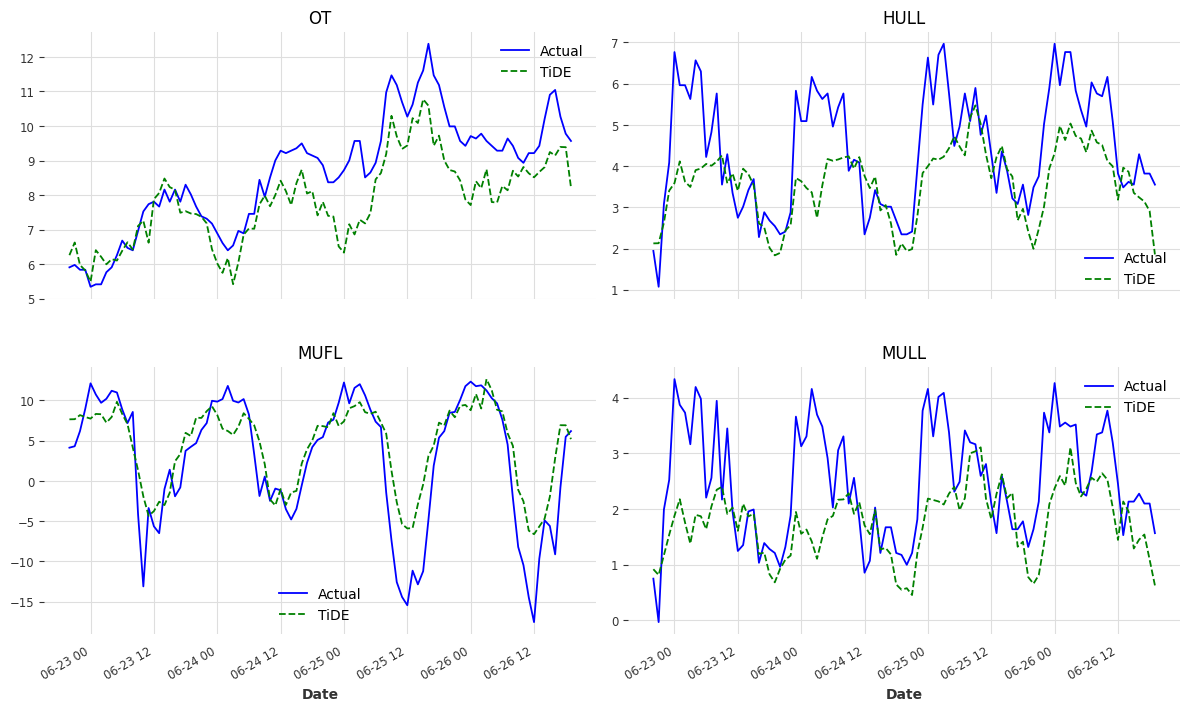

In [12]:
cols_to_plot = ['OT', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
        
    ax.plot(test_df[col], label='Actual', ls='-', color='blue')
    ax.plot(preds_df[col], label='TiDE', ls='--', color='green')
    
    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

In [13]:
from darts.metrics import mae, mse

tide_mae = mae(test, pred_tide)
tide_mse = mse(test, pred_tide)

print(tide_mae, tide_mse)

1.4471707941916638 6.235777932482635
